In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

In [11]:
data = pd.read_csv('./DataSet_HAR.csv')
y = data.values[:, 562]
X = data.values[:, 0:561].astype('float16')
realLabels = {'STANDING':0, 'WALKING':1, 'SITTING':2, 'LAYING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5}
Labels = ['STANDING', 'WALKING', 'SITTING', 'LAYING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']

for i in range(len(y)):
    y[i] = realLabels[y[i]]
y = y.astype('float16')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype = torch.float)
X_test = torch.tensor(X_test, dtype = torch.float)
y_train = torch.tensor(y_train, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)


In [14]:
class Net(nn.Module):
    # Defining shape and activation functions of the network
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(561, 100)
        self.fc2 = nn.Linear(100, 6)
        # Network with input layer (561 nodes), 1 hidden layer (100 nodes), and the output layer (6 nodes)
        
        
        
    def forward(self, x):
        # All layers use a sigmoid activation function
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        #return F.log_softmax(x, dim = 1)
        return torch.sigmoid(x)
net = Net()

# Optimizer
optimizer = torch.optim.Adam(net.parameters())

# Loss Function
criterion = nn.CrossEntropyLoss()

# Maximum Epochs to train for
nepochs = 20000
train, target = X_train, y_train

In [15]:
# run the main training loop
for epoch in range(nepochs):
    optimizer.zero_grad()
    # forward propagate
    net_out = net(train)
    # compute loss
    loss = criterion(net_out.squeeze(), target)
    # backpropagate
    loss.backward()
    # update parameters
    optimizer.step()
    # print out report
    if epoch % 1000 == 0:
        print('Epoch ', epoch, 'Loss ', loss.item())
        net_out = net(train)
        pred = net_out.data.squeeze()
        _, pred_i = torch.max(pred, 1)
        correctidx = pred_i.eq(target) 
        print('Predictions: ', pred_i[40:60])
        print('Real :       ', target[40:60])
        ncorrect = correctidx.sum()
        accuracy = ncorrect.item()/len(y_train)
        print('Training accuracy is ', accuracy)
        if accuracy >= .999:
            break


Epoch  0 Loss  1.7948284149169922
Predictions:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Real :        tensor([3, 0, 2, 1, 0, 0, 3, 0, 2, 0, 1, 4, 4, 2, 3, 3, 2, 2, 3, 0])
Training accuracy is  0.1884937492414128
Epoch  1000 Loss  1.0990431308746338
Predictions:  tensor([3, 2, 2, 1, 2, 2, 3, 2, 2, 2, 1, 4, 4, 2, 3, 3, 2, 2, 3, 2])
Real :        tensor([3, 0, 2, 1, 0, 0, 3, 0, 2, 0, 1, 4, 4, 2, 3, 3, 2, 2, 3, 0])
Training accuracy is  0.8312902051219808
Epoch  2000 Loss  1.0870064496994019
Predictions:  tensor([3, 0, 2, 1, 0, 2, 3, 0, 2, 0, 1, 4, 4, 2, 3, 3, 2, 2, 3, 0])
Real :        tensor([3, 0, 2, 1, 0, 0, 3, 0, 2, 0, 1, 4, 4, 2, 3, 3, 2, 2, 3, 0])
Training accuracy is  0.9168588420924869
Epoch  3000 Loss  1.0509989261627197
Predictions:  tensor([3, 0, 2, 1, 0, 0, 3, 0, 2, 0, 1, 4, 4, 2, 3, 3, 2, 2, 3, 0])
Real :        tensor([3, 0, 2, 1, 0, 0, 3, 0, 2, 0, 1, 4, 4, 2, 3, 3, 2, 2, 3, 0])
Training accuracy is  0.9919893190921228
Epoch  4000 Loss  1.0465068

Accuracy is 0.999636


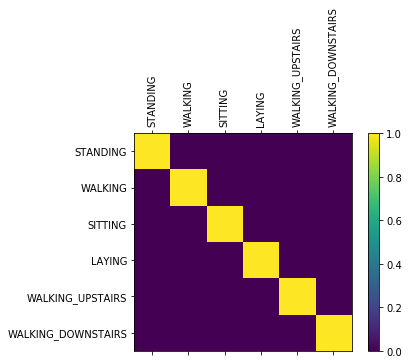

In [16]:
# Evaluating the Results
# ======================
# Code Snippet from Project 2.1 of DSC 275, provided by Ajay Anand and Edgar Bernal
# Edited to work with current network

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(6, 6)

# Code for evaluating the model's accuracy on every datapoint
for i in range(len(y_train)):
    point, label = X_train[i], y_train[i]
    output = net(point)
    _, category = torch.max(output, 0)
    confusion[label.item()][category.item()] += 1

    
accuracy = sum(confusion.diag())/sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(6):
    confusion[i] = confusion[i] / confusion[i].sum()

# Classification 
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + Labels, rotation=90)
ax.set_yticklabels([''] + Labels)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [19]:
#Find Accuracy on Testing Data
net_out = net(X_test)
pred = net_out.data.squeeze()
_, pred_i = torch.max(pred, 1)
#print('len of pred_i', len(pred_i))
correctidx = pred_i.eq(y_test) 
print('Predictions: ', pred_i[40:60])
print('Real :       ', target[40:60])
ncorrect = correctidx.sum()
accuracy = ncorrect.item()/len(y_test)
print('Testing accuracy is ', accuracy)
wrong = len(y_test)-ncorrect
print("Only ", wrong.item(), " classifications incorrect out of ", len(y_test), " predictions.")

Predictions:  tensor([3, 4, 1, 4, 3, 3, 5, 2, 2, 2, 0, 2, 3, 0, 5, 3, 3, 4, 3, 3])
Real :        tensor([3, 0, 2, 1, 0, 0, 3, 0, 2, 0, 1, 4, 4, 2, 3, 3, 2, 2, 3, 0])
Testing accuracy is  0.9893203883495145
Only  22  classifications incorrect out of  2060  predictions.
